In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import seaborn as sns
import math
from pyts.image import RecurrencePlot, GramianAngularField
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPool2D, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import load_model, Sequential
import json
import time
from collections import deque
import warnings
from pickle import dump, load

file_path = '/Users/mymac/Google Drive/My Drive/Forex_Robot/'

In [2]:
news = pd.read_csv(file_path + 'events_2018-2022.csv')
news = news.rename(columns={'Start': 'Date'})
news.Date = pd.to_datetime(news.Date)
news = news.loc[(news['Currency'] == 'AUD') | (news['Currency'] == 'USD')]
news.drop(['Id', 'Name', 'Currency'], axis=1, inplace=True)
news.drop(news[(news['Impact'] != 'LOW') & (news['Impact'] != 'MEDIUM') & (news['Impact'] != 'HIGH')].index, inplace=True)
news.loc[news['Impact'] == 'LOW', 'Impact'] = 1
news.loc[news['Impact'] == 'MEDIUM', 'Impact'] = 2
news.loc[news['Impact'] == 'HIGH', 'Impact'] = 3
news = news.groupby('Date')['Impact'].mean().reset_index()
news.head()

,Date,Impact
0,2018-01-01 22:30:00,2.0
1,2018-01-02 05:30:00,1.0
2,2018-01-02 14:45:00,2.0
3,2018-01-02 16:30:00,1.0
4,2018-01-02 18:00:00,1.0


In [3]:
df = pd.read_csv(file_path + 'Oanda_Aud_Usd_M5_2018-2022.csv')
df.Date = pd.to_datetime(df.Date)
df.reset_index(drop=True, inplace=True)
df.shape

(295406, 14)

In [4]:
df = pd.merge(df, news, how='left', on='Date')
df.reset_index(drop=True, inplace=True)
df = df.fillna(method='ffill')
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)
df.shape

(295317, 15)

In [5]:
df

,Date,Bid_Open,Bid_High,Bid_Low,Bid_Close,Ask_Open,Ask_High,Ask_Low,Ask_Close,Mid_Open,Mid_High,Mid_Low,Mid_Close,Volume,Impact
0,2018-01-02 05:30:00,0.78395,0.78395,0.78381,0.78389,0.78410,0.78410,0.78396,0.78402,0.78402,0.78402,0.78388,0.78396,18,1.0
1,2018-01-02 05:35:00,0.78389,0.78392,0.78364,0.78366,0.78402,0.78406,0.78378,0.78380,0.78396,0.78399,0.78371,0.78373,14,1.0
2,2018-01-02 05:40:00,0.78371,0.78395,0.78367,0.78395,0.78383,0.78409,0.78381,0.78409,0.78377,0.78402,0.78374,0.78402,12,1.0
3,2018-01-02 05:45:00,0.78389,0.78413,0.78389,0.78402,0.78403,0.78426,0.78403,0.78416,0.78396,0.78420,0.78396,0.78409,17,1.0
4,2018-01-02 05:50:00,0.78396,0.78396,0.78363,0.78371,0.78410,0.78410,0.78377,0.78386,0.78403,0.78403,0.78370,0.78378,27,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295312,2021-12-31 21:35:00,0.72694,0.72694,0.72673,0.72685,0.72714,0.72714,0.72691,0.72702,0.72704,0.72704,0.72682,0.72694,14,1.0
295313,2021-12-31 21:40:00,0.72681,0.72684,0.72663,0.72673,0.72699,0.72704,0.72686,0.72692,0.72690,0.72694,0.72674,0.72682,9,1.0
295314,2021-12-31 21:45:00,0.72676,0.72676,0.72661,0.72668,0.72696,0.72696,0.72683,0.72690,0.72686,0.72686,0.72672,0.72679,7,1.0
295315,2021-12-31 21:50:00,0.72672,0.72722,0.72672,0.72714,0.72693,0.72748,0.72693,0.72732,0.72682,0.72735,0.72682,0.72723,27,1.0


,Date,Bid_Open,Bid_High,Bid_Low,Bid_Close,Ask_Open,Ask_High,Ask_Low,Ask_Close,Mid_Open,Mid_High,Mid_Low,Mid_Close,Volume,Impact,sin_hour,cos_hour,sin_day,cos_day
0,2018-01-02 05:30:00,0.78395,0.78395,0.78381,0.78389,0.78410,0.78410,0.78396,0.78402,0.78402,0.78402,0.78388,0.78396,18,1.0,0.965926,0.258819,0.974928,-0.222521
1,2018-01-02 05:35:00,0.78389,0.78392,0.78364,0.78366,0.78402,0.78406,0.78378,0.78380,0.78396,0.78399,0.78371,0.78373,14,1.0,0.965926,0.258819,0.974928,-0.222521
2,2018-01-02 05:40:00,0.78371,0.78395,0.78367,0.78395,0.78383,0.78409,0.78381,0.78409,0.78377,0.78402,0.78374,0.78402,12,1.0,0.965926,0.258819,0.974928,-0.222521
3,2018-01-02 05:45:00,0.78389,0.78413,0.78389,0.78402,0.78403,0.78426,0.78403,0.78416,0.78396,0.78420,0.78396,0.78409,17,1.0,0.965926,0.258819,0.974928,-0.222521
4,2018-01-02 05:50:00,0.78396,0.78396,0.78363,0.78371,0.78410,0.78410,0.78377,0.78386,0.78403,0.78403,0.78370,0.78378,27,1.0,0.965926,0.258819,0.974928,-0.222521


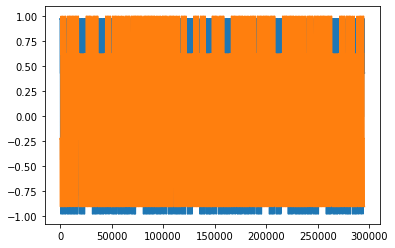

In [6]:
# Add hour of day, day of week, and month of year (for additional features)
# Use sine and cosine to keep the cyclic nature of hour, day, and month
#  (December is closer to January than October, midnight is closer to 1 am than
#  10 pm, etc.)
df['sin_hour'] = np.sin(2 * np.pi * df['Date'].dt.hour / 24)
df['cos_hour'] = np.cos(2 * np.pi * df['Date'].dt.hour / 24)
df['sin_day'] = np.sin(2 * np.pi * df['Date'].dt.day / 7)
df['cos_day'] = np.cos(2 * np.pi * df['Date'].dt.day / 7)

# Plots to illustrate cyclic nature of time
df.sin_day.plot()
df.cos_day.plot()

# Show the updated dataframe
df.head()

In [7]:
def psar(barsdata, iaf=0.02, maxaf=0.2):
    length = len(barsdata)
    high = list(barsdata['Mid_High'])
    low = list(barsdata['Mid_Low'])
    close = list(barsdata['Mid_Close'])
    psar = close[0:len(close)]
    bull = True
    af = iaf
    hp = high[0]
    lp = low[0]
    for i in range(2, length):
        if bull:
            psar[i] = psar[i - 1] + af * (hp - psar[i - 1])
        else:
            psar[i] = psar[i - 1] + af * (lp - psar[i - 1])
        reverse = False
        if bull:
            if low[i] < psar[i]:
                bull = False
                reverse = True
                psar[i] = hp
                lp = low[i]
                af = iaf
        else:
            if high[i] > psar[i]:
                bull = True
                reverse = True
                psar[i] = lp
                hp = high[i]
                af = iaf
        if not reverse:
            if bull:
                if high[i] > hp:
                    hp = high[i]
                    af = min(af + iaf, maxaf)
                if low[i - 1] < psar[i]:
                    psar[i] = low[i - 1]
                if low[i - 2] < psar[i]:
                    psar[i] = low[i - 2]
            else:
                if low[i] < lp:
                    lp = low[i]
                    af = min(af + iaf, maxaf)
                if high[i - 1] > psar[i]:
                    psar[i] = high[i - 1]
                if high[i - 2] > psar[i]:
                    psar[i] = high[i - 2]
    return psar

def atr(barsdata, lookback=14):
    high_low = barsdata['Mid_High'] - barsdata['Mid_Low']
    high_close = np.abs(
        barsdata['Mid_High'] - barsdata['Mid_Close'].shift())
    low_close = np.abs(
        barsdata['Mid_Low'] - barsdata['Mid_Close'].shift())
    ranges = pd.concat([high_low, high_close, low_close], axis=1)
    true_range = np.max(ranges, axis=1)

    return true_range.rolling(lookback).sum() / lookback

def rsi(barsdata, periods=14):
    close_delta = barsdata['Mid_Close'].diff()

    up = close_delta.clip(lower=0)
    down = -1 * close_delta.clip(upper=0)
    ma_up = up.ewm(com=periods - 1, adjust=True,
                    min_periods=periods).mean()
    ma_down = down.ewm(com=periods - 1, adjust=True,
                        min_periods=periods).mean()

    rsi = ma_up / ma_down
    rsi = 100 - (100/(1 + rsi))

    return rsi

def adx(high, low, close, lookback=14):
    plus_dm = high.diff()
    minus_dm = low.diff()
    plus_dm[plus_dm < 0] = 0
    minus_dm[minus_dm > 0] = 0

    tr1 = pd.DataFrame(high - low)
    tr2 = pd.DataFrame(abs(high - close.shift(1)))
    tr3 = pd.DataFrame(abs(low - close.shift(1)))
    frames = [tr1, tr2, tr3]
    tr = pd.concat(frames, axis=1, join='inner').max(axis=1)
    atr = tr.rolling(lookback).mean()

    plus_di = 100 * (plus_dm.ewm(alpha=1/lookback).mean() / atr)
    minus_di = abs(100 * (minus_dm.ewm(alpha=1/lookback).mean() / atr))
    dx = (abs(plus_di - minus_di) / abs(plus_di + minus_di)) * 100
    adx = ((dx.shift(1) * (lookback - 1)) + dx) / lookback
    adx_smooth = adx.ewm(alpha=1/lookback).mean()

    return adx_smooth

def stoch(high, low, close, lookback=14):
    high_lookback = high.rolling(lookback).max()
    low_lookback = low.rolling(lookback).min()
    slow_k = (close - low_lookback) * 100 / \
        (high_lookback - low_lookback)
    slow_d = slow_k.rolling(3).mean()

    return slow_k, slow_d

def stoch_rsi(data, k_window=3, d_window=3, window=14):
    min_val = data.rolling(window=window, center=False).min()
    max_val = data.rolling(window=window, center=False).max()

    stoch = ((data - min_val) / (max_val - min_val)) * 100

    slow_k = stoch.rolling(window=k_window, center=False).mean()

    slow_d = slow_k.rolling(window=d_window, center=False).mean()

    return slow_k, slow_d

def n_macd(macd, macdsignal, lookback=50):
    n_macd = 2 * (((macd - macd.rolling(lookback).min()) /
                    (macd.rolling(lookback).max() - macd.rolling(lookback).min()))) - 1
    n_macdsignal = 2 * (((macdsignal - macdsignal.rolling(lookback).min()) / (
        macdsignal.rolling(lookback).max() - macdsignal.rolling(lookback).min()))) - 1

    return n_macd, n_macdsignal

def chop(df, lookback=14):
    atr1 = atr(df, lookback=1)
    high, low = df['Mid_High'], df['Mid_Low']

    chop = np.log10(atr1.rolling(lookback).sum(
    ) / (high.rolling(lookback).max() - low.rolling(lookback).min())) / np.log10(lookback)

    return chop

def vo(volume, short_lookback=18, long_lookback=36):
    short_ema = pd.Series.ewm(volume, span=short_lookback).mean()
    long_ema = pd.Series.ewm(volume, span=long_lookback).mean()

    volume_oscillator = (short_ema - long_ema) / long_ema

    return volume_oscillator

In [8]:
# Add technical indicators (for additional features)
df['ema200'] = pd.Series.ewm(df['Mid_Close'], span=200).mean()
df['ema100'] = pd.Series.ewm(df['Mid_Close'], span=100).mean()
df['ema50'] = pd.Series.ewm(df['Mid_Close'], span=50).mean()
df['ema25'] = pd.Series.ewm(df['Mid_Close'], span=25).mean()

df['atr'] = atr(df)
df['rsi'] = rsi(df)
df['rsi_sma'] = df['rsi'].rolling(100).mean()
df['adx'] = adx(df['Mid_High'], df['Mid_Low'], df['Mid_Close'])
df['macd'] = pd.Series.ewm(df['Mid_Close'], span=12).mean() - pd.Series.ewm(df['Mid_Close'], span=26).mean()
df['macdsignal'] = pd.Series.ewm(df['macd'], span=9).mean()
df['slowk'], df['slowd'] = stoch(df['Mid_High'], df['Mid_Low'], df['Mid_Close'])
df['slowk_rsi'], df['slowd_rsi'] = stoch_rsi(df['rsi'])

df['sar'] = psar(df)

df['chop14'] = chop(df)
df['chop36'] = chop(df, lookback=36)

df['vo'] = vo(df['Volume'])

df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)

# Extract the bid and ask prices and fractals and remove them from the df
bid_ask_mid_prices = df[['Bid_Open', 'Bid_High', 'Bid_Low', 'Bid_Close', 'Ask_Open', 'Ask_High', 'Ask_Low', 'Ask_Close', 'Mid_Open', 'Mid_High', 'Mid_Low', 'Mid_Close']]
df.drop(['Bid_Open', 'Bid_High', 'Bid_Low', 'Bid_Close', 'Ask_Open', 'Ask_High', 'Ask_Low', 'Ask_Close'], axis=1, inplace=True)

print(df)

                      Date  Mid_Open  Mid_High  Mid_Low  Mid_Close  Volume  \
0      2018-01-02 14:55:00   0.78218   0.78233  0.78202    0.78202      51   
1      2018-01-02 15:00:00   0.78206   0.78272  0.78206    0.78243      75   
2      2018-01-02 15:05:00   0.78248   0.78260  0.78220    0.78243      44   
3      2018-01-02 15:10:00   0.78241   0.78250  0.78208    0.78220      57   
4      2018-01-02 15:15:00   0.78221   0.78263  0.78212    0.78260      48   
...                    ...       ...       ...      ...        ...     ...   
295199 2021-12-31 21:35:00   0.72704   0.72704  0.72682    0.72694      14   
295200 2021-12-31 21:40:00   0.72690   0.72694  0.72674    0.72682       9   
295201 2021-12-31 21:45:00   0.72686   0.72686  0.72672    0.72679       7   
295202 2021-12-31 21:50:00   0.72682   0.72735  0.72682    0.72723      27   
295203 2021-12-31 21:55:00   0.72720   0.72720  0.72685    0.72685      12   

        Impact  sin_hour  cos_hour   sin_day  ...      macd  ma

In [9]:
print(bid_ask_mid_prices)

        Bid_Open  Bid_High  Bid_Low  Bid_Close  Ask_Open  Ask_High  Ask_Low  \
0        0.78211   0.78226  0.78196    0.78196   0.78225   0.78240  0.78209   
1        0.78200   0.78264  0.78200    0.78236   0.78213   0.78279  0.78213   
2        0.78242   0.78253  0.78213    0.78236   0.78255   0.78267  0.78226   
3        0.78235   0.78243  0.78201    0.78214   0.78247   0.78257  0.78216   
4        0.78215   0.78257  0.78206    0.78253   0.78227   0.78271  0.78219   
...          ...       ...      ...        ...       ...       ...      ...   
295199   0.72694   0.72694  0.72673    0.72685   0.72714   0.72714  0.72691   
295200   0.72681   0.72684  0.72663    0.72673   0.72699   0.72704  0.72686   
295201   0.72676   0.72676  0.72661    0.72668   0.72696   0.72696  0.72683   
295202   0.72672   0.72722  0.72672    0.72714   0.72693   0.72748  0.72693   
295203   0.72712   0.72712  0.72672    0.72672   0.72727   0.72727  0.72698   

        Ask_Close  Mid_Open  Mid_High  Mid_Low  Mid

In [10]:
idx_cutoff = df.loc[df['Date'] > '2021-01-01 00:00:00'].index.to_list()[0]

test_df = df.iloc[idx_cutoff:, :]
test_bid_ask_mid_prices = bid_ask_mid_prices.iloc[idx_cutoff:, :]
df = df.iloc[0:idx_cutoff, :]
bid_ask_mid_prices = bid_ask_mid_prices.iloc[0:idx_cutoff, :]

df.reset_index(drop=True, inplace=True)
bid_ask_mid_prices.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)
test_bid_ask_mid_prices.reset_index(drop=True, inplace=True)

print(len(df))
print(len(bid_ask_mid_prices))
print(len(test_df))
print(len(test_bid_ask_mid_prices))


220971
220971
74233
74233


In [11]:
look_back_size = 500

In [12]:
def grab_image_data(subset):
  # rp_transformer = RecurrencePlot()
  # rp_subset = rp_transformer.transform(subset)

  # return rp_subset

  gasf_transformer = GramianAngularField(method='summation')
  gasf_subset = gasf_transformer.transform(subset)

  return gasf_subset

  # gadf_transformer = GramianAngularField(method='difference')
  # gadf_subset = gadf_transformer.transform(subset)

  # return gadf_subset

  # image_data = np.append(rp_subset, gasf_subset, axis=-1)
  # image_data = np.append(image_data, gadf_subset ,axis=-1)
  
  # return image_data

In [13]:
# buys = ['12/29/20 10:20', '12/30/20 20:30', '12/31/20 09:55', '02/11/21 11:20', '02/19/21 19:40', '02/25/21 03:15', '03/02/21 23:15', '03/09/21 16:45', '03/11/21 01:30', '04/06/21 23:25', '04/26/21 06:55', '05/10/21 03:10', '05/17/21 21:40', '07/05/21 04:40', '07/05/21 06:10', '07/05/21 14:30', '07/22/21 01:15', '08/04/21 06:10', '08/23/21 07:35', '08/24/21 01:15', '08/24/21 09:15', '09/10/21 07:00', '10/11/21 04:45', '10/14/21 02:40', '10/19/21 13:25', '11/15/21 00:45', '12/07/21 00:40', '12/09/21 01:25', '12/15/21 11:45', '12/16/21 05:55']
# sells = ['01/08/21 21:30', '01/11/21 09:40', '01/15/21 10:50', '01/15/21 17:35', '01/18/21 03:00', '02/04/21 23:40', '02/16/21 19:45', '02/26/21 03:15', '02/26/21 09:00', '02/26/21 14:40', '03/05/21 06:30', '03/23/21 15:25', '04/22/21 16:45', '04/27/21 12:05', '05/03/21 01:15', '05/11/21 03:10', '05/12/21 07:55', '05/13/21 02:05', '05/19/21 17:15', '05/28/21 09:05', '06/03/21 10:25', '06/09/21 18:30', '07/07/21 23:00', '07/08/21 17:05', '07/13/21 16:20', '08/20/21 04:30', '10/21/21 15:10', '11/05/21 00:05', '11/11/21 06:55', '11/16/21 12:20','12/03/21 06:20', '12/13/21 20:10', '12/17/21 09:05', '12/17/21 13:45']
# nones = ['12/28/20 22:10', '01/04/21 22:55', '01/07/21 01:30', '01/07/21 19:55', '01/12/21 11:35', '01/14/21 22:50', '01/14/21 23:45', '01/19/21 06:20', '01/19/21 21:55', '01/26/21 09:50', '01/28/21 22:15', '01/29/21 00:05', '02/15/21 10:15', '02/22/21 03:50', '02/22/21 21:30', '02/23/21 04:00', '02/25/21 12:25', '02/25/21 13:25', '03/01/21 18:35', '03/01/21 21:35', '03/01/21 23:50', '03/04/21 02:15', '03/05/21 19:10', '03/08/21 11:45', '03/08/21 14:25', '03/09/21 22:45', '03/11/21 11:45', '03/12/21 13:40', '03/16/21 19:10', '03/17/21 07:10', '03/19/21 05:05', '03/22/21 20:30', '03/25/21 01:05', '03/25/21 20:55', '03/30/21 22:25', '03/30/21 22:55', '04/02/21 07:40', '04/07/21 11:55', '04/08/21 00:50', '04/13/21 06:40', '04/15/21 16:05', '04/15/21 22:05', '04/19/21 12:45', '04/19/21 13:40', '04/19/21 14:30', '04/20/21 23:00', '04/20/21 08:50', '04/19/21 23:05', '04/26/21 20:40', '04/26/21 21:10', '04/28/21 09:10', '04/29/21 19:20', '05/03/21 20:35', '05/04/21 19:00', '05/04/21 20:35', '05/07/21 01:30', '05/07/21 03:15', '05/10/21 15:15', '05/18/21 11:25', '05/20/21 01:10', '05/25/21 08:50', '05/27/21 03:10', '05/27/21 04:25', '05/28/21 15:00', '06/02/21 13:05', '06/03/21 20:50', '06/03/21 23:55', '06/07/21 02:20', '06/10/21 02:05', '06/10/21 20:55', '06/10/21 21:40', '06/15/21 18:25', '06/15/21 32:00', '06/21/21 21:55', '06/23/21 17:35', '06/23/21 19:15', '06/30/21 00:50', '07/06/21 04:45', '07/06/21 23:55', '07/07/21 04:45', '07/07/21 06:05', '07/09/21 04:15', '07/09/21 05:55', '07/12/21 01:00', '07/13/21 05:10', '07/13/21 06:40', '07/15/21 21:30', '07/15/21 21:50', '07/15/21 23:05', '07/20/21 00:45', '07/22/21 22:00', '07/26/21 19:35', '08/02/21 04:25', '08/03/21 09:30', '08/04/21 12:35', '08/05/21 00:35', '08/05/21 18:05', '08/06/21 07:00', '08/09/21 02:50', '08/10/21 01:20', '08/11/21 19:35', '08/11/21 20:50', '08/11/21 21:35', '08/13/21 08:20', '08/13/21 18:55', '08/16/21 09:05', '08/19/21 12:50', '08/20/21 11:00', '08/20/21 12:10', '08/23/21 21:30', '08/23/21 21:55', '08/24/21 16:50', '08/25/21 00:00', '08/27/21 02:55', '08/27/21 05:05', '08/30/21 04:05', '08/31/21 10:10', '09/01/21 20:30', '09/02/21 17:40', '09/03/21 15:00', '09/20/21 06:10', '09/21/21 19:50', '09/28/21 19:25', '09/28/21 20:50', '09/29/21 00:45', '09/30/21 01:15', '10/01/21 20:05', '10/04/21 15:50', '10/05/21 20:10', '10/07/21 03:40', '10/07/21 13:35', '10/11/21 18:30', '10/12/21 13:45', '10/18/21 08:20', '10/19/21 21:15', '10/21/21 12:10', '10/21/21 12:55', '10/21/21 22:35', '10/22/21 20:15', '10/28/21 03:20', '10/28/21 05:05', '10/29/21 18:20', '10/29/21 19:10', '10/29/21 20:30', '11/01/21 10:30', '11/02/21 20:30', '11/03/21 00:15', '11/03/21 01:45', '11/03/21 04:20', '11/04/21 02:25', '11/04/21 20:00', '11/05/21 19:10', '11/08/21 20:50', '11/12/21 00:50', '11/15/21 15:50', '11/15/21 18:05', '11/17/21 22:40', '11/18/21 00:25', '11/22/21 02:35', '11/23/21 08:00', '11/25/21 16:05', '11/26/21 09:35', '11/26/21 10:40', '11/26/21 11:35', '11/29/21 18:55', '11/30/21 08:40', '12/02/21 00:00', '12/03/21 12:55', '12/06/21 02:20', '12/06/21 05:05', '12/08/21 23:40']

# print(len(buys))
# print(len(sells))
# print(len(nones))

In [14]:
# buy_indices = [df.index[df['Date'] == curr_date] + 1 for curr_date in buys]
# sell_indices = [df.index[df['Date'] == curr_date] + 1 for curr_date in sells]
# nones_indices = [df.index[df['Date'] == curr_date] + 1 for curr_date in nones]

# print(len(buy_indices))
# print(len(sell_indices))
# print(len(nones_indices))

In [23]:
buys = []
sells = []
nones = []

value_per_pip = 1.0
amounts_per_day = [-0.00008, -0.0001, -0.00012]
spread_cutoff = 0.00025
n_units = 50000
risk_reward_ratio = 1.5
trade = None

def calculate_day_fees(start_date, end_date, n_units):
    curr_fee = np.random.choice(amounts_per_day, p=[0.25, 0.50, 0.25]) * n_units
    num_days = np.busday_count(start_date.date(), end_date.date())

    return num_days * curr_fee

for i in range(look_back_size, len(df)):
    curr_date = df.loc[df.index[i], 'Date']
    ema200_2, ema100_2, ema50_2, ema25_2, atr2, sar2, rsi2, rsi_sma2, mid_open2, mid_close2, mid_low2, mid_high2, vo2 = df.loc[df.index[i - 2], ['ema200', 'ema100', 'ema50', 'ema25', 'atr', 'sar', 'rsi', 'rsi_sma', 'Mid_Open', 'Mid_Close', 'Mid_Low', 'Mid_High', 'vo']]
    ema200_1, ema100_1, ema50_1, ema25_1, atr1, sar1, rsi1, rsi_sma1, mid_open1, mid_close1, mid_low1, mid_high1, vo1 = df.loc[df.index[i - 1], ['ema200', 'ema100', 'ema50', 'ema25', 'atr', 'sar', 'rsi', 'rsi_sma', 'Mid_Open', 'Mid_Close', 'Mid_Low', 'Mid_High', 'vo']]
    curr_ao = bid_ask_mid_prices.loc[bid_ask_mid_prices.index[i], 'Ask_Open']
    curr_bo = bid_ask_mid_prices.loc[bid_ask_mid_prices.index[i], 'Bid_Open']
    impact = df.loc[df.index[i - 1], 'Impact']
    spread = abs(curr_ao - curr_bo)
    enough_volatility = spread <= spread_cutoff
    macd2, macdsignal2 = df.loc[df.index[i - 2], ['macd', 'macdsignal']]
    macd1, macdsignal1 = df.loc[df.index[i - 1], ['macd', 'macdsignal']]
    macd_vals = [0, macd2, macdsignal2, macd1, macdsignal1]
    curr_bid_open, curr_bid_high, curr_bid_low, curr_bid_close, curr_ask_open, curr_ask_high, curr_ask_low, curr_ask_close = \
        bid_ask_mid_prices.loc[bid_ask_mid_prices.index[i], ['Bid_Open', 'Bid_High', 'Bid_Low', 'Bid_Close', 'Ask_Open', 'Ask_High',
                            'Ask_Low', 'Ask_Close']]
    chop2 = df.loc[df.index[i - 2], 'chop36']
    chop1 = df.loc[df.index[i - 1], 'chop36']

    emas_buy_signal = ema200_1 < mid_close1
    emas_sell_signal = ema200_1 > mid_close1

    # macd_buy_signal = macd2 < macdsignal2 and macd1 > macdsignal1 and max(macd_vals) == 0
    # macd_sell_signal = macd2 > macdsignal2 and macd1 < macdsignal1 and min(macd_vals) == 0
    macd_buy_signal = macd2 < macdsignal2 and macd1 > macdsignal1 and max(macd_vals) == 0
    macd_sell_signal = macd2 > macdsignal2 and macd1 < macdsignal1 and min(macd_vals) == 0

    sar_buy_signal = sar1 < min([mid_open1, mid_close1])
    sar_sell_signal = sar1 > max([mid_open1, mid_close1])

    rsi_buy_signal = rsi2 < rsi1 and rsi1 > rsi_sma1 and rsi1 > 50
    rsi_sell_signal = rsi2 > rsi1 and rsi1 < rsi_sma1 and rsi1 < 50

    chop_signal = max([chop2, chop1]) < 0.55
    # chop_signal = chop1 < 0.50

    vo_signal = min([vo2, vo1]) > 0.0

    impact_signal = impact >= 2.5
    # impact_signal = True

    if trade is None:
        if macd_buy_signal and emas_buy_signal and sar_buy_signal and rsi_buy_signal and enough_volatility and chop_signal and vo_signal and impact_signal:
            open_price = float(curr_ao)
            pullback = sar1

            stop_loss = round(pullback, 5)

            if stop_loss < open_price:
                curr_pips_to_risk = open_price - stop_loss

                stop_gain = round(open_price + (curr_pips_to_risk * risk_reward_ratio), 5)

                trade = {'open_price': open_price, 'trade_type': 'buy', 'stop_loss': stop_loss,
                                                    'stop_gain': stop_gain, 'pips_risked': round(curr_pips_to_risk, 5),
                                                    'n_units': n_units, 'original_units': n_units, 'start_date': curr_date, 'end_date': None}

        elif macd_sell_signal and emas_sell_signal and sar_sell_signal and rsi_sell_signal and enough_volatility and chop_signal and vo_signal and impact_signal:
            open_price = float(curr_bo)
            pullback = sar1

            stop_loss = round(pullback, 5)

            if stop_loss > open_price:
                curr_pips_to_risk = stop_loss - open_price

                stop_gain = round(open_price - (curr_pips_to_risk * risk_reward_ratio), 5)

                trade = {'open_price': open_price, 'trade_type': 'sell', 'stop_loss': stop_loss,
                        'stop_gain': stop_gain, 'pips_risked': round(curr_pips_to_risk, 5),
                        'n_units': n_units, 'original_units': n_units, 'start_date': curr_date, 'end_date': None}

    if trade is not None:
        for j in range(i, len(df)):
            curr_date = df.loc[df.index[j], 'Date']
            curr_bid_open, curr_bid_high, curr_bid_low, curr_bid_close, curr_ask_open, curr_ask_high, curr_ask_low, curr_ask_close = bid_ask_mid_prices.loc[bid_ask_mid_prices.index[j], ['Bid_Open', 'Bid_High', 'Bid_Low', 'Bid_Close', 'Ask_Open', 'Ask_High', 'Ask_Low', 'Ask_Close']]

            if trade['trade_type'] == 'buy' and curr_bid_low <= trade['stop_loss']:
                nones.append(trade['start_date'])  

                trade = None
                break

            if trade['trade_type'] == 'buy' and curr_bid_high >= trade['stop_gain']:
                trade_amount = 100 * risk_reward_ratio
                day_fees = calculate_day_fees(trade['start_date'], curr_date, trade['n_units'])

                if trade_amount + day_fees > 0:
                    buys.append(trade['start_date'])

                trade = None
                break

            if trade['trade_type'] == 'sell' and curr_ask_high >= trade['stop_loss']:
                nones.append(trade['start_date'])


                trade = None
                break

            if trade['trade_type'] == 'sell' and curr_ask_low <= trade['stop_gain']:
                trade_amount = 100 * risk_reward_ratio
                day_fees = calculate_day_fees(trade['start_date'], curr_date, trade['n_units'])

                if trade_amount + day_fees > 0:
                    sells.append(trade['start_date'])

                trade = None
                break

print(len(buys))
print(len(sells))
print(len(nones))

6
8
20


In [16]:
buy_indices = [df.index[df['Date'] == curr_date] - 1 for curr_date in buys]
sell_indices = [df.index[df['Date'] == curr_date] - 1 for curr_date in sells]
nones_indices = [df.index[df['Date'] == curr_date] - 1 for curr_date in nones]

print(len(buy_indices))
print(len(sell_indices))
print(len(nones_indices))

270
304
778


In [17]:
def get_sequential_data(input_df):
    no_actions = []
    buys = []
    sells = []

    for i in buy_indices:
        if len(i) == 1:
            i = i[0]
            seq = df.iloc[i - look_back_size + 1:i + 1, 1:]
            seq = grab_image_data(seq)
            buys.append([seq, np.array([0, 1, 0])])

    for i in sell_indices:
        if len(i) == 1:
            i = i[0]
            seq = df.iloc[i - look_back_size + 1:i + 1, 1:]
            seq = grab_image_data(seq)
            sells.append([seq, np.array([0, 0, 1])])

    for i in nones_indices:
        if len(i) == 1:
            i = i[0]
            seq = df.iloc[i - look_back_size + 1:i + 1, 1:]
            seq = grab_image_data(seq)
            no_actions.append([seq, np.array([1, 0, 0])])

    np.random.shuffle(no_actions)
    np.random.shuffle(buys)
    np.random.shuffle(sells)

    lower = min(len(no_actions), len(buys), len(sells))

    no_actions = no_actions[:int(lower * 2)]

    sequential_data = no_actions + buys + sells
    np.random.shuffle(sequential_data)

    return sequential_data

In [18]:
sequential_data = get_sequential_data(df)

In [19]:
len(sequential_data)

1114

In [20]:
training_proportion = 0.70
train_test_cutoff_index = int(len(sequential_data) * training_proportion)

train_set = sequential_data[0:train_test_cutoff_index]
test_set = sequential_data[train_test_cutoff_index:]

print('Dataset shapes:')
print(len(train_set))
print(len(test_set))

Dataset shapes:
779
335


In [21]:
x_train = []
y_train = []

for seq, target in train_set:
  x_train.append(seq)
  y_train.append(target)

x_test = []
y_test = []

for seq, target in test_set:
  x_test.append(seq)
  y_test.append(target)

x_train = np.array(x_train)
y_train = np.array(y_train)
x_test = np.array(x_test)
y_test = np.array(y_test)

In [22]:
x_train.shape

(779, 500, 28, 28)

In [30]:
y_train.shape

(779, 3)

In [31]:
# Number of possible actions to take - determines the output dimension of the
#  neural network
n_actions = 3
input_data_shape = x_train.shape[1:]

model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (3,3), padding ='Same', 
                 activation ='relu', input_shape = input_data_shape))
model.add(Conv2D(filters = 64, kernel_size = (3,3), padding = 'Same', 
                 activation ='relu'))

model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(128, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(n_actions, activation = "softmax"))

In [32]:
# Hyperparameters
n_epochs = 500
batch_size = 32
n_steps = len(x_train) // batch_size 
mean_loss = tf.keras.metrics.Mean() 
optimizer = tf.keras.optimizers.Adam()
loss_fn = tf.keras.losses.categorical_crossentropy
metrics = [tf.keras.metrics.CategoricalAccuracy()]
# loss_fn = tf.keras.losses.MeanAbsoluteError
# metrics = [tf.keras.metrics.MeanAbsoluteError()]


average_training_losses = []
average_test_accuracies = []

In [33]:
early_stop = EarlyStopping(monitor='val_accuracy', verbose=1, patience=n_epochs)
model_checkpoint = ModelCheckpoint('/Users/mymac/forex_macd_cnn', monitor='val_accuracy', save_best_only=True, verbose=1)

optimizer = Adam()

model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [34]:
history = model.fit(
    x_train, y_train,
    batch_size=batch_size,
    epochs=n_epochs,
    validation_data=(x_test, y_test),
    callbacks=[early_stop, model_checkpoint]
)

Epoch 1/500
25/25 [==============================] - ETA: 0s - loss: 9.0240 - accuracy: 0.3851
Epoch 00001: val_accuracy improved from -inf to 0.48060, saving model to /Users/mymac/forex_macd_cnn
INFO:tensorflow:Assets written to: /Users/mymac/forex_macd_cnn/assets
25/25 [==============================] - 14s 565ms/step - loss: 9.0240 - accuracy: 0.3851 - val_loss: 1.0728 - val_accuracy: 0.4806
Epoch 2/500
25/25 [==============================] - ETA: 0s - loss: 1.0620 - accuracy: 0.4865
Epoch 00002: val_accuracy did not improve from 0.48060
25/25 [==============================] - 11s 461ms/step - loss: 1.0620 - accuracy: 0.4865 - val_loss: 1.0579 - val_accuracy: 0.4806
Epoch 3/500
25/25 [==============================] - ETA: 0s - loss: 1.0652 - accuracy: 0.4865
Epoch 00003: val_accuracy did not improve from 0.48060
25/25 [==============================] - 11s 463ms/step - loss: 1.0652 - accuracy: 0.4865 - val_loss: 1.0545 - val_accuracy: 0.4806
Epoch 4/500
25/25 [===================

In [35]:
model = load_model('/Users/mymac/forex_macd_cnn')

# test_df = pd.read_csv(file_path + 'Oanda_Gbp_Usd_M15_2020-2021.csv')
# test_df.Date = pd.to_datetime(test_df.Date)
# test_df.reset_index(drop=True, inplace=True)

# test_df_small = pd.read_csv(file_path + 'Oanda_Gbp_Usd_M5_2020-2021.csv')
# test_df_small.Date = pd.to_datetime(test_df_small.Date)
# test_df_small.reset_index(drop=True, inplace=True)

In [36]:
proba_threshold = 0.99

value_per_pip = 1.0
amounts_per_day = [-0.00008, -0.0001, -0.00012]
spread_cutoff = 0.00025
n_units = 50000
risk_reward_ratio = 1.0
reward = 0
buys = 0
sells = 0
n_wins = 0
n_losses = 0
trade = None

def calculate_day_fees(start_date, end_date, n_units):
    curr_fee = np.random.choice(amounts_per_day, p=[0.25, 0.50, 0.25]) * n_units
    num_days = np.busday_count(start_date.date(), end_date.date())

    return num_days * curr_fee

for i in range(look_back_size, len(test_df)):
    curr_date = test_df.loc[test_df.index[i], 'Date']
    ema200_2, ema100_2, ema50_2, ema25_2, atr2, sar2, rsi2, rsi_sma2, mid_open2, mid_close2, mid_low2, mid_high2, vo2 = test_df.loc[test_df.index[i - 2], ['ema200', 'ema100', 'ema50', 'ema25', 'atr', 'sar', 'rsi', 'rsi_sma', 'Mid_Open', 'Mid_Close', 'Mid_Low', 'Mid_High', 'vo']]
    ema200_1, ema100_1, ema50_1, ema25_1, atr1, sar1, rsi1, rsi_sma1, mid_open1, mid_close1, mid_low1, mid_high1, vo1 = test_df.loc[test_df.index[i - 1], ['ema200', 'ema100', 'ema50', 'ema25', 'atr', 'sar', 'rsi', 'rsi_sma', 'Mid_Open', 'Mid_Close', 'Mid_Low', 'Mid_High', 'vo']]
    curr_ao = test_bid_ask_mid_prices.loc[test_bid_ask_mid_prices.index[i], 'Ask_Open']
    curr_bo = test_bid_ask_mid_prices.loc[test_bid_ask_mid_prices.index[i], 'Bid_Open']
    spread = abs(curr_ao - curr_bo)
    enough_volatility = spread <= spread_cutoff
    macd2, macdsignal2 = test_df.loc[test_df.index[i - 2], ['macd', 'macdsignal']]
    macd1, macdsignal1 = test_df.loc[test_df.index[i - 1], ['macd', 'macdsignal']]
    macd_vals = [0, macd2, macdsignal2, macd1, macdsignal1]
    curr_bid_open, curr_bid_high, curr_bid_low, curr_bid_close, curr_ask_open, curr_ask_high, curr_ask_low, curr_ask_close = \
        test_bid_ask_mid_prices.loc[test_bid_ask_mid_prices.index[i], ['Bid_Open', 'Bid_High', 'Bid_Low', 'Bid_Close', 'Ask_Open', 'Ask_High',
                            'Ask_Low', 'Ask_Close']]
    chop2 = test_df.loc[test_df.index[i - 2], 'chop36']
    chop1 = test_df.loc[test_df.index[i - 1], 'chop36']

    emas_buy_signal = ema200_1 < mid_close1
    emas_sell_signal = ema200_1 > mid_close1

    # macd_buy_signal = macd2 < macdsignal2 and macd1 > macdsignal1 and max(macd_vals) == 0
    # macd_sell_signal = macd2 > macdsignal2 and macd1 < macdsignal1 and min(macd_vals) == 0
    macd_buy_signal = macd2 < macdsignal2 and macd1 > macdsignal1
    macd_sell_signal = macd2 > macdsignal2 and macd1 < macdsignal1

    sar_buy_signal = sar1 < min([mid_open1, mid_close1])
    sar_sell_signal = sar1 > max([mid_open1, mid_close1])

    rsi_buy_signal = rsi2 < rsi1 and rsi1 > rsi_sma1 and rsi1 > 50
    rsi_sell_signal = rsi2 > rsi1 and rsi1 < rsi_sma1 and rsi1 < 50

    chop_signal = max([chop2, chop1]) < 0.55

    vo_signal = min([vo2, vo1]) > 0

    if trade is None:
        if macd_buy_signal and emas_buy_signal and sar_buy_signal and rsi_buy_signal and enough_volatility and chop_signal and vo_signal:
            open_price = float(curr_ao)
            pullback = sar1

            stop_loss = round(pullback, 5)

            if stop_loss < open_price:
                curr_pips_to_risk = open_price - stop_loss

                stop_gain = round(open_price + (curr_pips_to_risk * risk_reward_ratio), 5)

                curr_seq = np.array(test_df.iloc[i - look_back_size:i, 1:])
                curr_seq = grab_image_data(curr_seq)
                pred = model.predict(curr_seq.reshape(1, look_back_size, x_train.shape[-1], x_train.shape[-1]))
                argmax = np.argmax(pred)
                proba = pred[0][argmax]
                nn_buy_signal = argmax == 1 and proba >= proba_threshold

                if nn_buy_signal:
                    buys += 1
                    trade = {'open_price': open_price, 'trade_type': 'buy', 'stop_loss': stop_loss,
                                                        'stop_gain': stop_gain, 'pips_risked': round(curr_pips_to_risk, 5),
                                                        'n_units': n_units, 'original_units': n_units, 'start_date': curr_date, 'end_date': None}

        elif macd_sell_signal and emas_sell_signal and sar_sell_signal and rsi_sell_signal and enough_volatility and chop_signal and vo_signal:
            open_price = float(curr_bo)
            pullback = sar1

            stop_loss = round(pullback, 5)

            if stop_loss > open_price:
                curr_pips_to_risk = stop_loss - open_price

                stop_gain = round(open_price - (curr_pips_to_risk * risk_reward_ratio), 5)

                curr_seq = np.array(test_df.iloc[i - look_back_size:i, 1:])
                curr_seq = grab_image_data(curr_seq)
                pred = model.predict(curr_seq.reshape(1, look_back_size, x_train.shape[-1], x_train.shape[-1]))
                argmax = np.argmax(pred)
                proba = pred[0][argmax]
                nn_sell_signal = argmax == 2 and proba >= proba_threshold

                if nn_sell_signal:
                    sells += 1
                    trade = {'open_price': open_price, 'trade_type': 'sell', 'stop_loss': stop_loss,
                            'stop_gain': stop_gain, 'pips_risked': round(curr_pips_to_risk, 5),
                            'n_units': n_units, 'original_units': n_units, 'start_date': curr_date, 'end_date': None}

    if trade is not None:
        curr_date = test_df.loc[test_df.index[i], 'Date']
        curr_bid_open, curr_bid_high, curr_bid_low, curr_bid_close, curr_ask_open, curr_ask_high, curr_ask_low, curr_ask_close = test_bid_ask_mid_prices.loc[test_bid_ask_mid_prices.index[i], ['Bid_Open', 'Bid_High', 'Bid_Low', 'Bid_Close', 'Ask_Open', 'Ask_High', 'Ask_Low', 'Ask_Close']]

        if trade['trade_type'] == 'buy' and curr_bid_low <= trade['stop_loss']:
            reward += -100 
            n_losses += 1

            trade = None
            continue

        if trade['trade_type'] == 'buy' and curr_bid_high >= trade['stop_gain']:
            trade_amount = 100 * risk_reward_ratio
            day_fees = calculate_day_fees(trade['start_date'], curr_date, trade['n_units'])

            reward += trade_amount + day_fees
            n_wins += 1

            trade = None
            continue

        if trade['trade_type'] == 'sell' and curr_ask_high >= trade['stop_loss']:
            reward += -100
            n_losses += 1

            trade = None
            continue

        if trade['trade_type'] == 'sell' and curr_ask_low <= trade['stop_gain']:
            trade_amount = 100 * risk_reward_ratio
            day_fees = calculate_day_fees(trade['start_date'], curr_date, trade['n_units'])

            reward += trade_amount + day_fees
            n_wins += 1

            trade = None
            continue

print(reward)
print(buys)
print(sells)
print(n_wins)
print(n_losses)

-2200.0
32
46
28
50


In [28]:
def plot_candles(df_plot):
    fig = go.Figure()

    fig.add_trace(go.Candlestick(
        x=df_plot.Date, open=df_plot.Mid_Open, high=df_plot.Mid_High, low=df_plot.Mid_Low, close=df_plot.Mid_Close,
        line=dict(width=1), opacity=1,
        increasing_fillcolor='#24A06B',
        decreasing_fillcolor="#CC2E3C",
        increasing_line_color='#2EC886',
        decreasing_line_color='#FF3A4C'
    ))

    fig.add_trace(go.Scatter(
        x=df_plot.Date,
        y=df_plot['ema200'],
        marker=dict(color="yellow", size=10),
        name='EMA 200',
        mode='lines'
        ))

    fig.update_layout(width=1400,height=600,
        margin=dict(l=10,r=10,b=10,t=10),
        font=dict(size=10,color="#e1e1e1"),
        paper_bgcolor="#1e1e1e",
        plot_bgcolor="#1e1e1e")

    fig.update_xaxes(
        gridcolor="#1f292f",
        showgrid=True,fixedrange=True,rangeslider=dict(visible=False),
        rangebreaks=[
            dict(bounds=["sat", "mon"])
        ]
    )

    fig.update_yaxes(
        gridcolor="#1f292f",
        showgrid=True
    )

    fig1 = go.Figure()
    fig1.add_trace(go.Scatter(
        x=df_plot.Date,
        y=df_plot['macd'],
        marker=dict(color="green", size=10),
        name='MACD',
        mode='lines'
        ))

    fig1.add_trace(go.Scatter(
        x=df_plot.Date,
        y=df_plot['macdsignal'],
        marker=dict(color="red", size=10),
        name='MACDSIGNAL',
        mode='lines'
        ))

    fig1.update_layout(width=1400,height=200,
        margin=dict(l=10,r=10,b=10,t=10),
        font=dict(size=10,color="#e1e1e1"),
        paper_bgcolor="#1e1e1e",
        plot_bgcolor="#1e1e1e")

    fig1.update_xaxes(
        gridcolor="#1f292f",
        showgrid=True,fixedrange=True,rangeslider=dict(visible=False),
        rangebreaks=[
            dict(bounds=["sat", "mon"])
        ]
    )

    fig1.update_yaxes(
        gridcolor="#1f292f",
        showgrid=True
    )

    fig.show()
    fig1.show()

In [57]:
plot_candles(df.iloc[63530:63930, :])

In [56]:
sell_indices[24][0]

63537